In [20]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv
import plotly.express as px

pd.options.plotting.backend = "plotly"

In [21]:
def rk4_integrator(x_0, t_0, t_n, dt, dx, u):
    x = x_0
    t = t_0
    
    yield (x, t)
    
    while t <= t_n:
        # eval x_k+1 using x_k and t_k
        k1 = dx(x, t, u)
        k2 = dx(x + dt * k1 / 2, t + dt / 2, u)
        k3 = dx(x + dt * k2 / 2, t + dt / 2, u)
        k4 = dx(x + dt * k3, t + dt, u)
        
        x = x + dt * (k1 + 2*k2 + 2*k3 + k4) * (1/6)
        
        # t increament to t_k+1
        t = t + dt
        
        yield (x, t)

In [22]:
def plot_state_vs_time(df):    
    fig = df.plot()
    fig.update_layout(height=700)
    fig.show()

M = np.array([
    [25.8, 0, 0],
    [0, 33.8, 6.2],
    [0, 6.2, 2.76]
])

Bt = np.array([
    [1, 0],
    [0, 0],
    [0, 1]
])

Minv = inv(M)

def eta(u, v, sai):
    return np.array([u, v, sai]).T

def nu(x, y, r):
    return np.array([x, y, r]).T

# def x(x, y, r, u, v, sai):
#     return np.array([x, y, r, u, v, sai]).T

def C(V):
    u = V[0]
    v = V[1]
    r = V[2]
    c13 = -33.8*v -(6.2+6.2)*r/2
    c23 = 25.8*u
    return np.array([
        [0, 0, c13],
        [0, 0, c23],
        [-c13, -c23, 0]
    ])

# def D(V):
#     u = V[0]
#     v = V[1]
#     r = V[2]
#     return -np.array([
#         [-12 - 2.1 * abs(u), 0, 0],
#         [0, -17 - 4.5 * abs(v) , -0.2],
#         [0, -0.5, -0.5 - 0.1 * abs(r)]
#     ])

# To remove abs, we have to make sure force stays constant
def D(V):
    u = V[0]
    v = V[1]
    r = V[2]
    return -np.array([
        [-12 - 2.1 * u, 0, 0],
        [0, -17 - 4.5 * v , -0.2],
        [0, -0.5, -0.5 - 0.1 * -r]
    ])

def R(sai):
    return np.array([
        [np.cos(sai), -np.sin(sai), 0],
        [np.sin(sai), np.cos(sai), 0],
        [0, 0, 1]
    ])

def fx(V, sai):
    a = R(sai)@V
    b = -Minv@(C(V) + D(V))@V
    # print(np.array([a, b]).shape)
    c = np.array([a, b]).reshape(-1)
    return c


def B():
    a = np.array([
        [0, 0],
        [0, 0],
        [0, 0]
    ])
    b = Minv@Bt
    c = np.concatenate((a, b), axis=0)
    return c

# X = [x, y, r, u, v, sai]
def dx(X, t = None, U = np.array([0, 0])):
    V = X[3:]
    sai = X[2]
    return fx(V, sai) + B()@U

In [23]:
# Testing dX

dx(np.array([1, 2, 3, 4, 5, 6]), np.array([0, 0]))

array([ -4.66557003,  -4.38548245,   6.        ,  44.79069767,
        -6.03602684, -99.01327305])

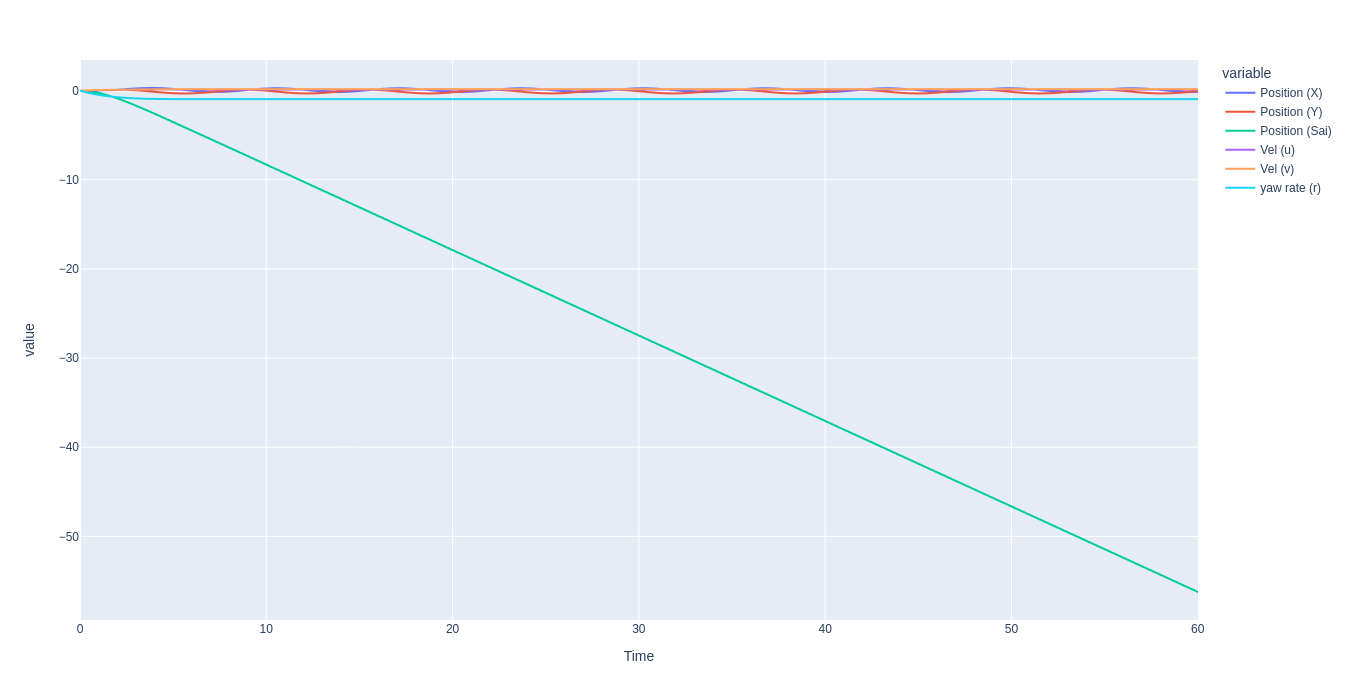

Position (X)  Position (Y)  Position (Sai)   Vel (u)   Vel (v)  \
Time                                                                     
0.000       0.000000      0.000000        0.000000  0.000000  0.000000   
0.016       0.000005      0.000014       -0.000079  0.000618  0.001794   
0.032       0.000020      0.000057       -0.000314  0.001231  0.003557   
0.048       0.000044      0.000128       -0.000703  0.001840  0.005291   
0.064       0.000079      0.000226       -0.001247  0.002444  0.006997   
...              ...           ...             ...       ...       ...   
59.952     -0.145497     -0.064440      -56.180208  0.110583  0.164950   
59.968     -0.144773     -0.061347      -56.195546  0.110583  0.164950   
59.984     -0.144002     -0.058264      -56.210883  0.110583  0.164950   
60.000     -0.143183     -0.055194      -56.226221  0.110583  0.164950   
60.016     -0.142318     -0.052137      -56.241558  0.110583  0.164950   

        yaw rate (r)  
Time                  
0.000       0.000000  
0.016      -0.009814  
0.032      -0.019538  
0.048      -0.029171  
0.064      -0.038716  
...              ...  
59.952     -0.958586  
59.968     -0.958586  
59.984     -0.958586  
60.000     -0.958586  
60.016     -0.958586  

[3752 rows x 6 columns]

In [24]:
# X_0 = np.array([3.5, 2, np.pi / 2, 1, -2, 1])

'''
initial conditions
x = 0
y = 0
sai = 90deg clockwise with y-axis
u = 0
v = 0
r = 0

F_u = 2
F_v = 1
'''
X_0 = np.array([0, 0, 0, 0, 0, 0])
U = [1, -1] 

t_0 = 0
T = 60
dt = 0.016

state_time = []
state_integrator = rk4_integrator(X_0, t_0, T, dt, dx, np.array(U))
for x, t in state_integrator:
    state_time.append({"Position (X)": x[0], "Position (Y)": x[1], "Position (Sai)": x[2], "Vel (u)": x[3], "Vel (v)": x[4], "yaw rate (r)": x[5], "Time": t})
r_state_time_df = pd.DataFrame(state_time).set_index("Time")

# state_time_df = pd.concat([r_state_time_df, e_state_time_df])
plot_state_vs_time(r_state_time_df)
r_state_time_df

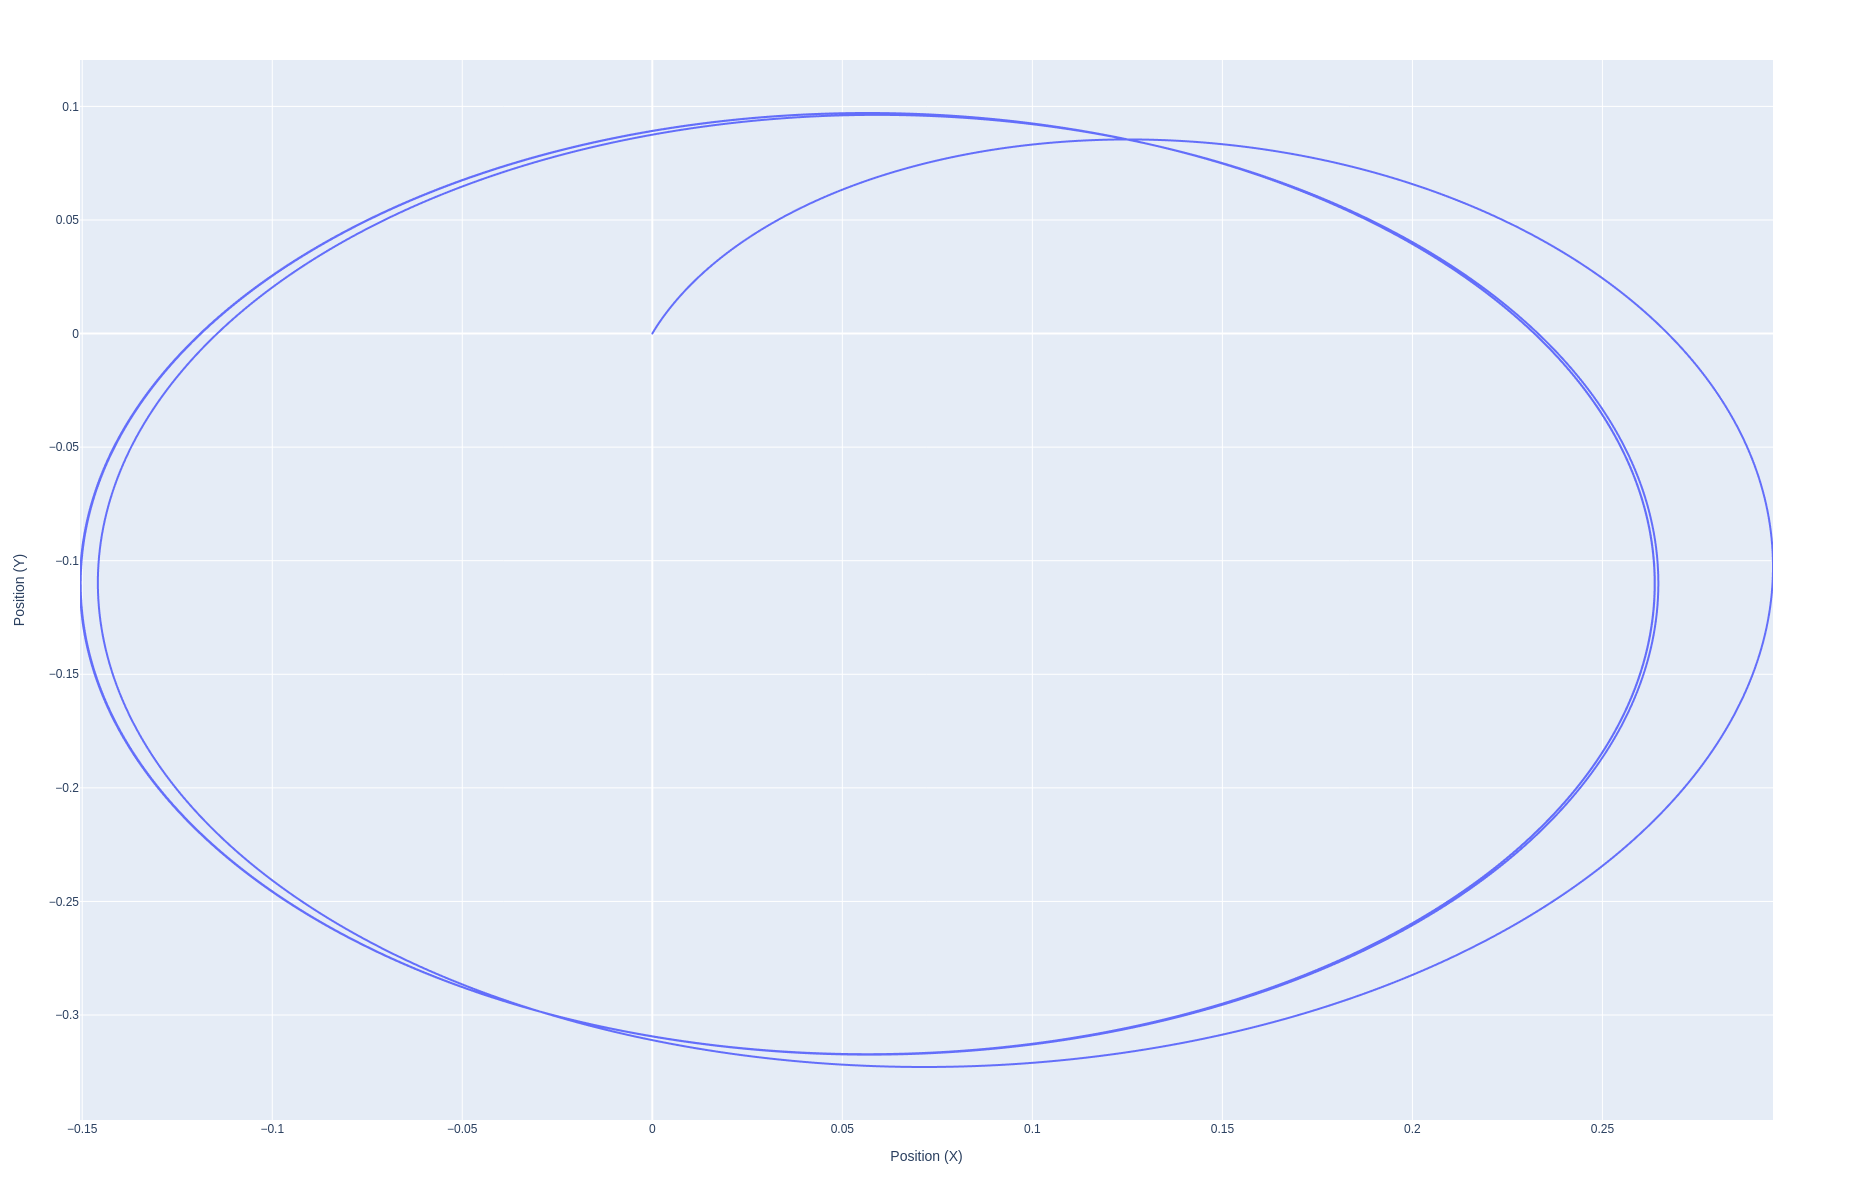

In [25]:
import plotly.express as px
fig = px.line(r_state_time_df, x='Position (X)', y='Position (Y)', height=1200)
fig.show()

In [26]:
Jf = lambda x,y,psi,u,v,r: (np.array([[0, 0, -u*math.sin(psi) - v*math.cos(psi), math.cos(psi), -math.sin(psi), 0], [0, 0, u*math.cos(psi) - v*math.sin(psi), math.sin(psi), math.cos(psi), 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, -0.162790697674419*u - 0.465116279069767, 1.31007751937984*r, 0.48062015503876*r + 1.31007751937984*v], [0, 0, 0, -0.597432905484247*r + 0.904317386231039*v, 0.904317386231039*u - 0.452887981330222*v - 0.798935239206535, -0.022607934655776*r - 0.597432905484247*u + 0.0464556592765461], [0, 0, 0, -0.904317386231039*r - 4.92998833138856*v, -4.92998833138856*u + 1.01735705950992*v + 1.61355017502917, 0.123249708284714*r - 0.904317386231039*u - 0.285516336056009]]))

# testing
Jf(1, 2, 1, 2, 1, 1)

array([[ 0.        ,  0.        , -2.22324428,  0.54030231, -0.84147098,
         0.        ],
       [ 0.        ,  0.        ,  0.23913363,  0.84147098,  0.54030231,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.        ,  0.        ,  0.        , -0.79069767,  1.31007752,
         1.79069767],
       [ 0.        ,  0.        ,  0.        ,  0.30688448,  0.55681155,
        -1.17101809],
       [ 0.        ,  0.        ,  0.        , -5.83430572, -7.22906943,
        -1.9709014 ]])

In [27]:
# state

In [28]:
num_states = 6

# Initial uncertainity (Start with high error) // co-variance matrix
P = np.diag([10.0 for _ in range(num_states)])
P

array([[10.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 10.]])

In [29]:
s_x = 1.0*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
s_y = 1.0*dt # assume 0.1rad/s as maximum turn rate for the vehicle
s_sai = 1.0*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
s_u = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
s_v = 1.0*dt
s_r = 1.0*dt

# Process Noise // co-variance matrix
Q = np.diag([s_x**2, s_y**2, s_sai**2, s_u**2, s_v**2, s_r**2])

In [30]:
# measurement function
# hx = Matrix([x, y, sai, u, v, r])

In [31]:
# Jh = hx.jacobian(state)
Jh = np.diag([1, 1, 1, 1, 1, 1]) # hard coded jacoban

In [32]:
var_x = 0.1 # Standard Deviation of GPS Measurement
var_y = 0.1
var_sai = 0.1 # Variance of the speed measurement
var_u = 0.1 # Variance of the yawrate measurement
var_v = 0.1
var_r = 0.1

# Measurement noise
R_ = np.diag([var_x**2, var_y**2, var_sai**2, var_u**2, var_v**2, var_r**2])
R_

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01]])

In [33]:
state_time = []
state_integrator = rk4_integrator(X_0, t_0, T, dt, dx, np.array(U))
for x, t in state_integrator:
    if t == 0:
        continue
    
    measurement = x
    
    # State Projection
    state_projection = x
    
    # Error projection
    Jf_x = Jf(x[0], x[1], x[2], x[3], x[4], x[5])
    P = Jf_x@P@Jf_x.T
    
    # Measurement Update (Correction)
    S = Jh@P@Jh.T + R_
    try:
        K = (P*Jh.T) * np.linalg.inv(S)
    except:
        print(t)
        print("------")
        print(P)
        print("------")
        print(R_)
        print("------")
        print(Jf_x)
        print("------")
        print(S)
        break
    
    # Update the estimate via measurement
    hx = x # remove unobservable state
    Z = measurement.reshape(Jh.shape[0],1)
    y = Z - (hx) # Innovation or Residual
    x = x.reshape(-1, 1) + (K*y) # Updated projection (x is the projection)

16.36799999999997
------
[[ 3.93376973e+12 -1.56201376e+13 -9.33502379e+12 -1.47198332e+13
   2.90322093e+12  1.58965858e+13]
 [-1.78482412e+13  3.53636543e+13  1.19154455e+13  4.61624970e+13
   4.77228675e+12 -4.37673878e+13]
 [-1.12450795e+13  1.42124620e+13  5.90843792e+11  2.43979876e+13
   7.08408738e+12 -2.11316168e+13]
 [-1.60139897e+13  4.29639344e+13  2.03218162e+13  4.79438254e+13
  -1.39582745e+12 -4.82419581e+13]
 [ 4.02924766e+12  1.94547774e+12  5.82164121e+12 -4.65420407e+12
  -6.09512680e+12  1.95082345e+12]
 [ 1.76760643e+13 -4.18294150e+13 -1.76357614e+13 -4.96708565e+13
  -1.28621431e+12  4.87815213e+13]]
------
[[0.01 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01]]
------
[[ 0.          0.          0.14978466 -0.26095442  0.96535112  0.        ]
 [ 0.          0.          0.13035595 -0.96535112 -0.26095442  0.        ]
 [ 0.

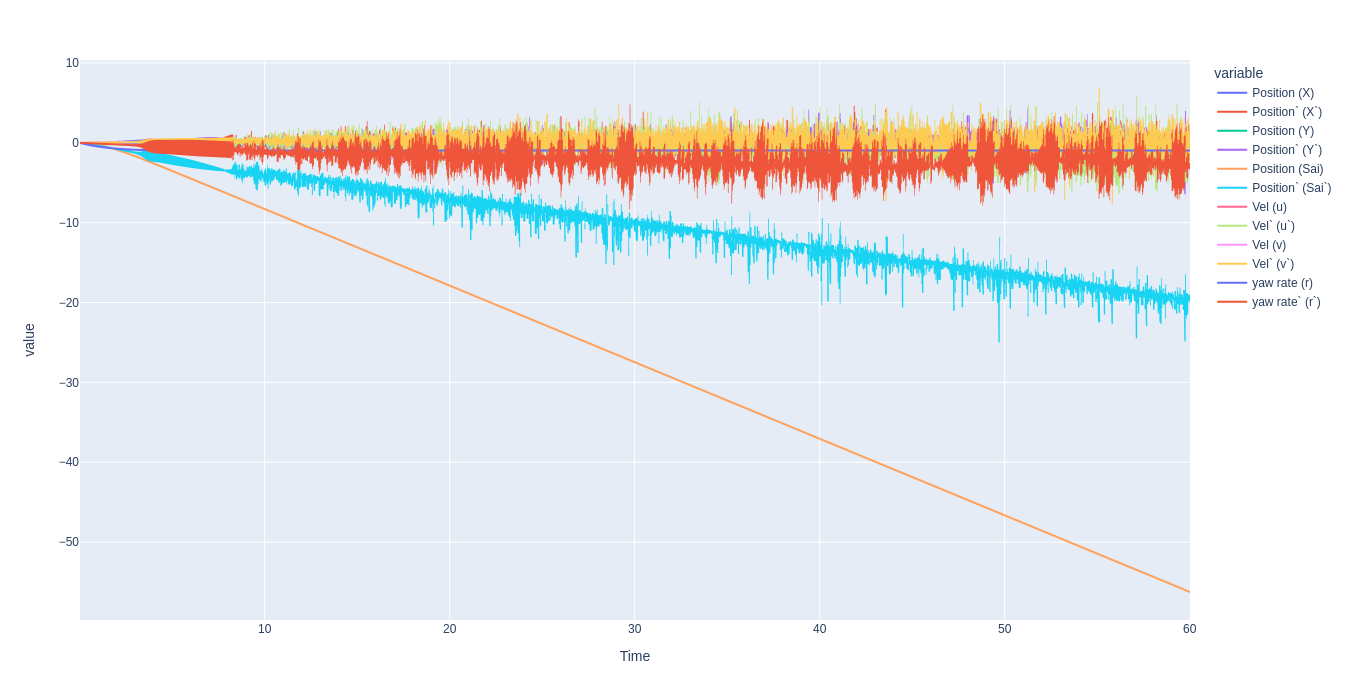

In [85]:
# AEKF
def run():
    X_0 = np.array([0, 0, 0, 0, 0, 0])
    U = [1, -1] 
    t_0 = 0
    T = 60
    dt = 0.016
    state_time = []
    
    num_states = 6

    QF = np.diag([0.1 for _ in range(num_states)])
    RF = np.diag([0.1 for _ in range(num_states)])
    C = np.identity(num_states)
    In = np.identity(num_states)
    Phi = B() @ np.diag(U)

    # Algo init
    x_hat = None # initialized in first step
    theta_hat = np.zeros((2, 1)) # unclear
    P_plus = np.diag([1 for _ in range(num_states)])
    # Upsilon = 0 # from paper
    Upsilon = 0 * B()
    S = 0.01 * np.identity(2) # from paper
    lamda = 0.997 # from paper

    
    state_integrator = rk4_integrator(X_0, t_0, T, dt, dx, np.array(U))
    for x, t in state_integrator:
        # initialize
        if t == 0:
            x_hat = x
        else:
            Jf_x_hat = Jf(x_hat[0], x_hat[1], x_hat[2], x_hat[3], x_hat[4], x_hat[5])

            y = C @ x # not sure
            y_tilda = (y - C @ x_hat).reshape((-1,1))

            P_minus = Jf_x_hat @ P_plus @ Jf_x_hat.T + QF
            Sigma = C @ P_minus @ C.T + RF
            K = P_minus @ C.T @ np.linalg.inv(Sigma)
            P_plus = (In - (K @ C)) @ np.linalg.inv(P_minus)

            Omega = (C @ Jf_x_hat @ Upsilon) + (C @ Phi)       
            Upsilon = ((In - (K @ C)) @ Jf_x_hat @ Upsilon) + (In - (K @ C)) @ Phi
            Lamda = np.linalg.inv( (lamda * Sigma) + (Omega @ S @ Omega.T) ) # why S put in middle?
            Gamma = S @ (Omega.T @ Lamda)
            S = S / lamda - S * (Omega.T @ Lamda @ Omega) * S / lamda # Why S not taken common

            theta_hat = theta_hat + Gamma @ y_tilda
            x_hat = dx(x).reshape((-1, 1)) + Phi @ theta_hat + K @ y_tilda + Upsilon @ Gamma @ y_tilda
            
            x_hat = x_hat.reshape(-1)
            
            state_time.append({
                "Position (X)": x[0], 
                "Position` (X`)": x_hat[0],
                "Position (Y)": x[1], 
                "Position` (Y`)": x_hat[1],
                "Position (Sai)": x[2], 
                "Position` (Sai`)": x_hat[2],
                "Vel (u)": x[3], 
                "Vel` (u`)": x_hat[3],
                "Vel (v)": x[4], 
                "Vel` (v`)": x_hat[4],
                "yaw rate (r)": x[5], 
                "yaw rate` (r`)": x_hat[5],
                "Time": t}
            )
            
    r_state_time_df = pd.DataFrame(state_time).set_index("Time")
    plot_state_vs_time(r_state_time_df)
run()